<center><h1>Segundo Práctico Series Temporales</h1></center>
<center><h2>Aplicación Holt-Winters exponential smoothing con datos de demanda de energía</h2></center>
<br>

En este práctico de utiliza una base de datos de la demanda de energía eléctrica por categoróa de consumidores, provista por CAMMESA

En la presente Notebook, la variable disponible y utilizada para el análisis consiste en el consumo de energía por residenciales

In [1]:
# Packages
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

In [2]:
# Plot settings
sns.set_context('notebook') 
sns.set_style('ticks')
red='#D62728'
blue='#1F77B4'
%matplotlib inline
plt.rcParams['figure.figsize'] = [15, 10]

## Data: Demanda Energía Residenciales
 

In [3]:
data = pd.read_csv('datasets/demanda.csv', index_col='TIPO', parse_dates=True, dayfirst=True)
data.tail()

,Residencial,Comercial,Industrial/Comercial Grande,TOTAL
TIPO,,,,
2019-03-01,4004709.444,3044854.983,3072063.284,1.012163e+07
2019-04-01,3652724.519,2892482.731,3029687.889,9.574895e+06
2019-05-01,4356836.823,2973830.213,3055527.035,1.038619e+07
2019-06-01,4816838.191,2937048.667,2897618.673,1.065151e+07
2019-07-01,5704951.016,3288949.873,3035538.422,1.202944e+07


In [4]:
y = data['Residencial'].copy() # Month period series
y.index = y.index.to_period(freq='M')

ts = data['Residencial'] # Day indexed series

In [5]:
y.describe().round(2)

count         79.00
mean     4551935.29
std       654164.93
min      3239380.70
25%      3990580.45
50%      4470715.12
75%      5092450.46
max      6193110.21
Name: Residencial, dtype: float64

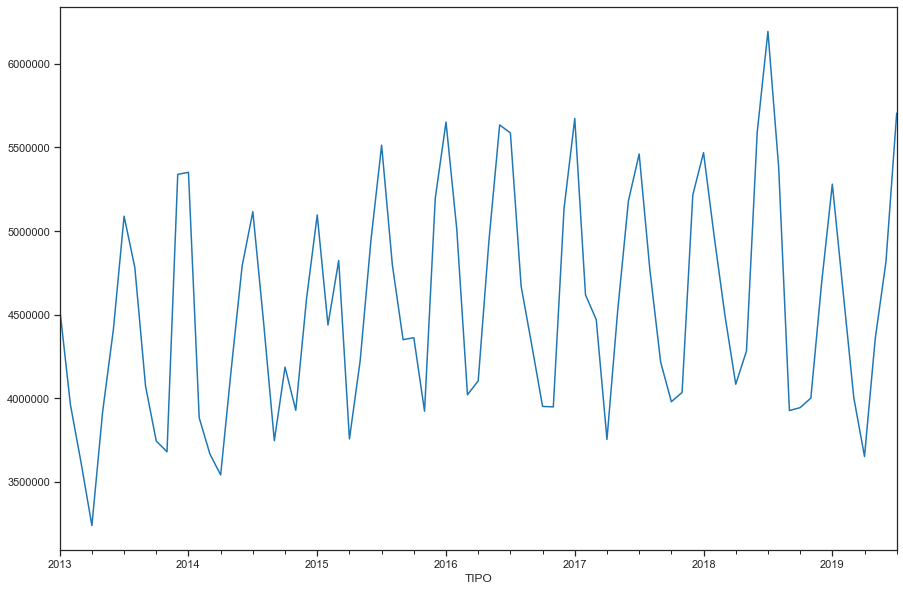

In [6]:
y.plot();#figsize=(9,6))

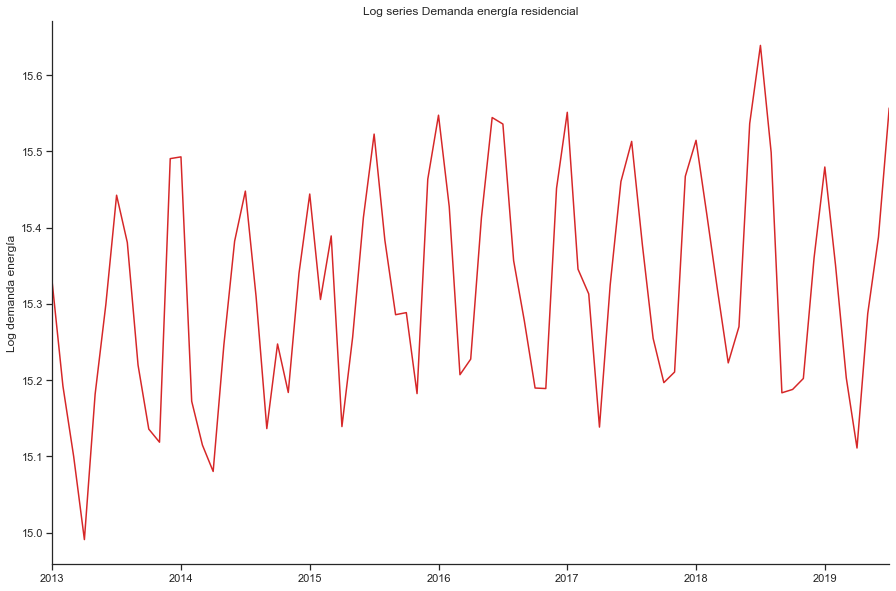

In [7]:
fig, ax= plt.subplots();#figsize=(9,6))
np.log(y).plot(color=red)
ax.set_xlabel('')
ax.set_ylabel('Log demanda energía')
ax.set_title('Log series Demanda energía residencial')
ax.set_xticks([], minor=True)
sns.despine()
plt.show()

El patrón se mantiene a lo largo de la serie, mostrando un fuerte componente estacional; caídas de la demanda de energía electrica en los meses de abril-mayo y septiembre octubre, y crecimiento de la demanda en los meses de enero-febrero y junio-julio.

## Descomposición de la serie temporal
 

In [8]:
decomposition = sm.tsa.x13_arima_analysis(ts,x12path='.')

C:\Users\valen\Anaconda3\envs\diplodatos\lib\site-packages\statsmodels\tsa\x13.py:187: X13Warning: WARNING: At least one visually significant trading day peak has been
          found in one or more of the estimated spectra.
  warn(errors, X13Warning)


In [9]:
[attr for attr in dir(decomposition) if not attr.startswith('_')]

['irregular', 'observed', 'plot', 'results', 'seasadj', 'stdout', 'trend']

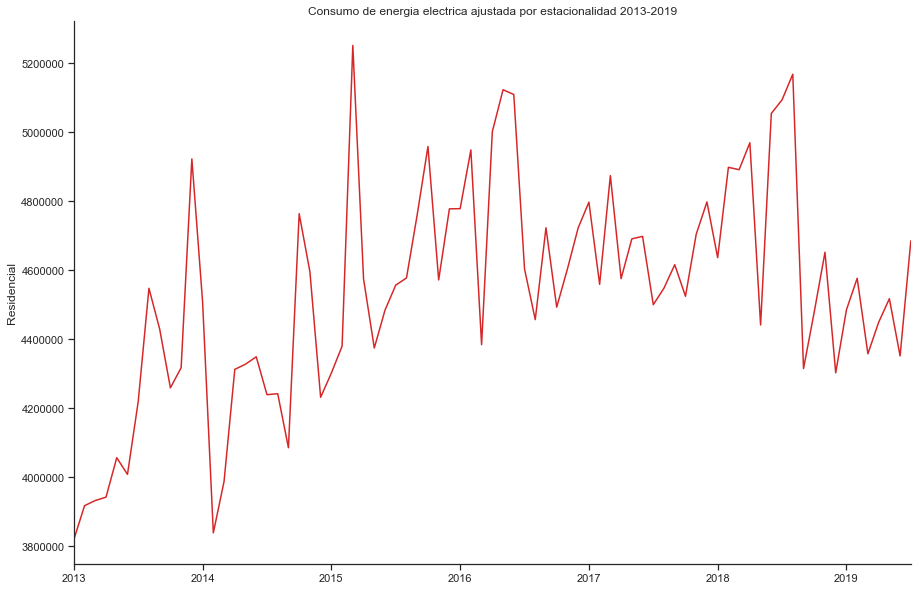

In [10]:
fig, ax= plt.subplots()
decomposition.seasadj.plot(color=red)
ax.set_xlabel('')
ax.set_ylabel('Residencial')
ax.set_title('Consumo de energia electrica ajustada por estacionalidad 2013-2019')
ax.set_xticks([], minor=True) 
sns.despine()
plt.show()

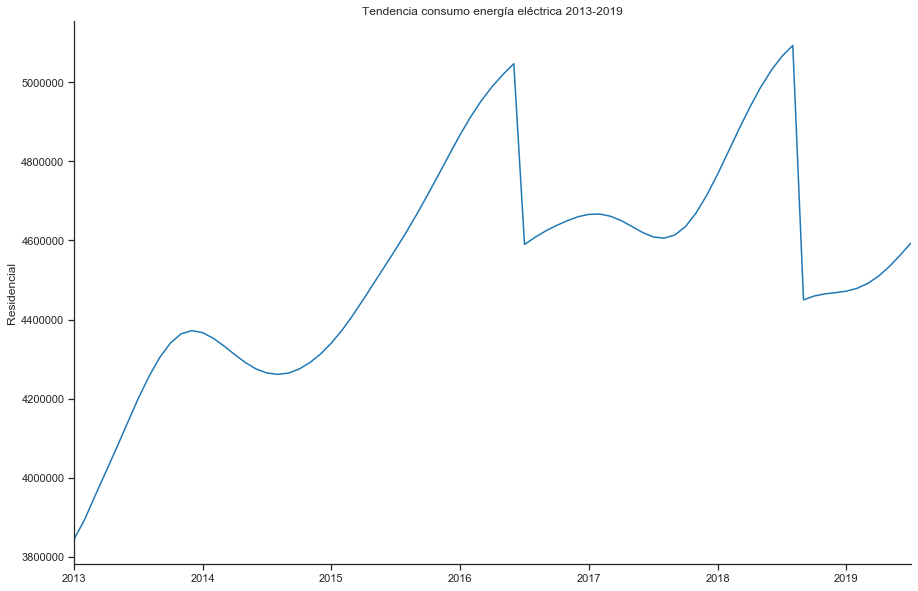

In [11]:
fig, ax= plt.subplots()
decomposition.trend.plot(color=blue)
ax.set_xlabel('')
ax.set_ylabel('Residencial')
ax.set_title('Tendencia consumo energía eléctrica 2013-2019')
ax.set_xticks([], minor=True)
sns.despine()
plt.show()

**Componentes de la serie**


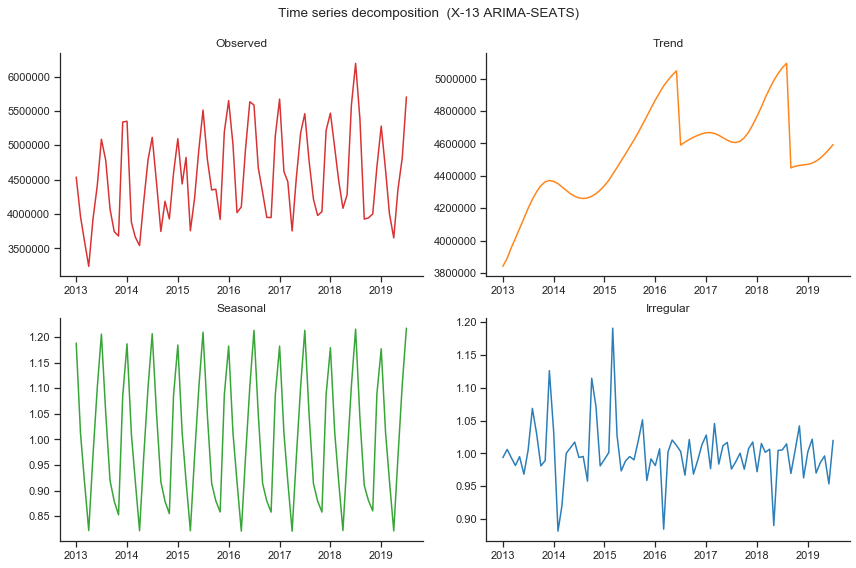

In [12]:
from plotting import plot_components_x13
plot_components_x13(decomposition)
plt.show()

1. serie original  2. tendencia  3. rescata la estacionalidad y 4. rescata el patron irregular

## Exponential smoothing con tendencia corregida

In [13]:
z=decomposition.seasadj.copy()
z.index=ts.index.to_period(freq='M')

Nos queda la serie quitandole la estacionalidad, solo maneja la tendencia

In [14]:
model_sm = sm.tsa.Holt(z).fit()
smoothed_sm = model_sm.fittedvalues
mse_sm = sm.tools.eval_measures.rmse(z,smoothed_sm)
print(' In-sample fit:')
print(' RMSE               {0:.3f}'.format(mse_sm))
model_sm.summary()

 In-sample fit:
 RMSE               258906.867


Dep. Variable:,endog,No. Observations:,79
Model:,Holt,SSE,5295588487281.475
Optimized:,True,AIC,1977.347
Trend:,Additive,BIC,1986.825
Seasonal:,None,AICC,1978.514
Seasonal Periods:,None,Date:,"Mon, 30 Sep 2019"
Box-Cox:,False,Time:,21:17:55
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.2389223,alpha,True
smoothing_slope,0.0572988,beta,True


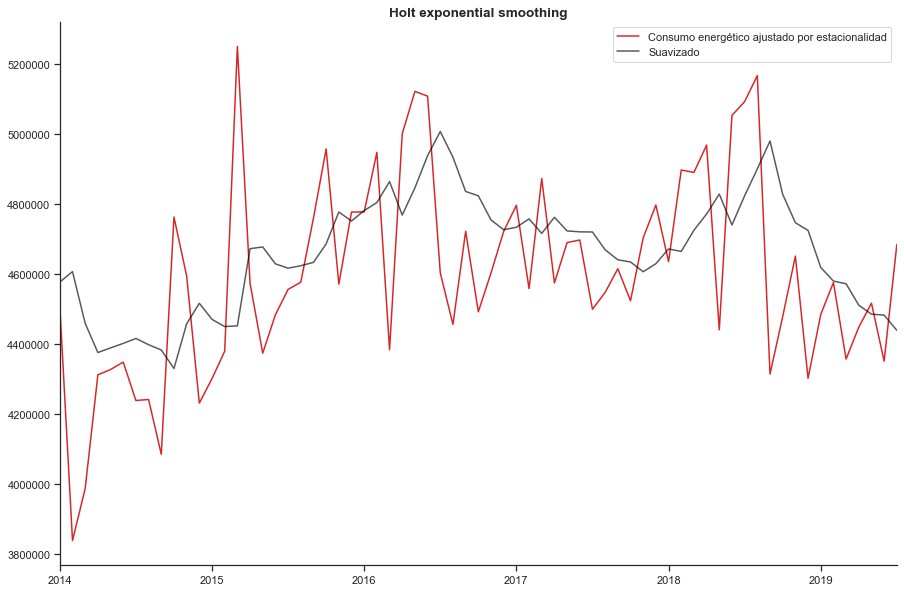

In [16]:
fig, ax= plt.subplots()

z['2014':].plot(color='#D62728', label='Consumo energético ajustado por estacionalidad')
smoothed_sm['2014':].plot(color='black', label='Suavizado', alpha=0.65)
plt.legend(loc='best')
ax.set_xlabel('')
ax.set_xticks([], minor=True)
ax.set_title(r'Holt exponential smoothing', fontsize=13.5, fontweight='bold')
sns.despine()
plt.show()

A continuación probamos predecir tanto con el modelo con rolling window como con expanding window.

C:\Users\valen\Anaconda3\envs\diplodatos\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


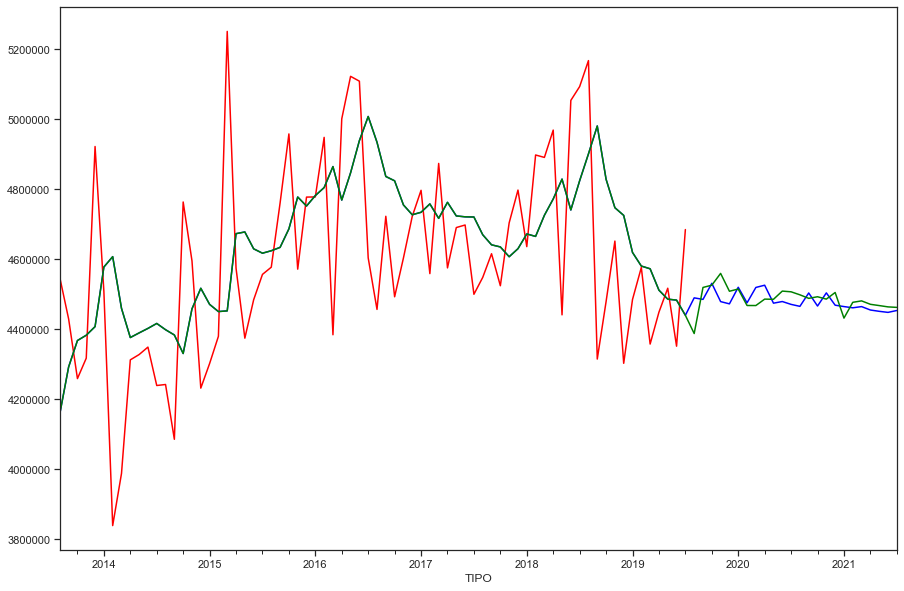

In [17]:
h=2*12 #M
w=h*3
data = z
model = sm.tsa.Holt
pred_index = data.index[-1] + np.array(range(1,h+1))
pred_rolling = pd.Series(0,index=pred_index)
pred_expanding = pd.Series(0,index=pred_index)
orig_fit = None
for i in range(0,h):
    current = pd.concat([data, pred_expanding.head(i)])
    expanding = model(current).fit()
    if i==0:
        orig_fit = expanding.fittedvalues
    rolling = model(current.tail(w)).fit()
    pred_expanding.update(expanding.forecast(1))
    pred_rolling.update(rolling.forecast(1))
ax = data[-w:].plot(color='red');#figsize=(9,6))
pd.concat([orig_fit[-w:],pred_expanding]).plot(ax=ax,color='blue');
pd.concat([orig_fit[-w:],pred_rolling]).plot(ax=ax,color='green');

## Holt-winters exponential smoothing

Se prueban distintos modelos para ver cual ajusta mejor a la serie

In [18]:
def hw_summary(model_sm):
    rmse_sm = sm.tools.eval_measures.rmse(model_sm.data.endog,model_sm.fittedvalues)
    print(' In-sample fit:')
    print(' RMSE               {0:.3f}'.format(rmse_sm))
    return model_sm.summary()

In [19]:
ahw_sm=sm.tsa.ExponentialSmoothing(y, trend='add', damped=False, 
                                   seasonal='add', seasonal_periods=12).fit()

#le pedimos que tanto la estacionalidad como la tendencia sean aditiva, en lugar de multiplicativa

In [20]:
hw_summary(ahw_sm)

 In-sample fit:
 RMSE               325019.910


Dep. Variable:,endog,No. Observations:,79
Model:,ExponentialSmoothing,SSE,8345397406747.049
Optimized:,True,AIC,2037.279
Trend:,Additive,BIC,2075.191
Seasonal:,Additive,AICC,2048.679
Seasonal Periods:,12,Date:,"Mon, 30 Sep 2019"
Box-Cox:,False,Time:,21:19:17
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.1013813,alpha,True
smoothing_slope,5.9572e-22,beta,True


In [21]:
mhw_sm=sm.tsa.ExponentialSmoothing(y, trend='add', damped=False, seasonal='mul', seasonal_periods=12).fit()
hw_summary(mhw_sm)

#Aca la estacionalidad es multiplicativa --> nos da un mejor ajuste

 In-sample fit:
 RMSE               249758.947


Dep. Variable:,endog,No. Observations:,79
Model:,ExponentialSmoothing,SSE,4927982984521.504
Optimized:,True,AIC,1995.664
Trend:,Additive,BIC,2033.575
Seasonal:,Multiplicative,AICC,2007.064
Seasonal Periods:,12,Date:,"Mon, 30 Sep 2019"
Box-Cox:,False,Time:,21:19:23
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.2749452,alpha,True
smoothing_slope,6.4215e-16,beta,True


In [22]:
mhw_damped=sm.tsa.ExponentialSmoothing(y, trend='add', damped=True, seasonal='mul', seasonal_periods=12).fit()
hw_summary(mhw_damped)

 In-sample fit:
 RMSE               250884.819


Dep. Variable:,endog,No. Observations:,79
Model:,ExponentialSmoothing,SSE,4972512204439.331
Optimized:,True,AIC,1998.374
Trend:,Additive,BIC,2038.655
Seasonal:,Multiplicative,AICC,2011.256
Seasonal Periods:,12,Date:,"Mon, 30 Sep 2019"
Box-Cox:,False,Time:,21:19:32
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.2915957,alpha,True
smoothing_slope,0.0526318,beta,True


El modelo con tendencia aditiva y estacionalidad multiplicativa y sin amortiguar la tendencia da la menor RMSE, por lo tanto usaremos este modelo.

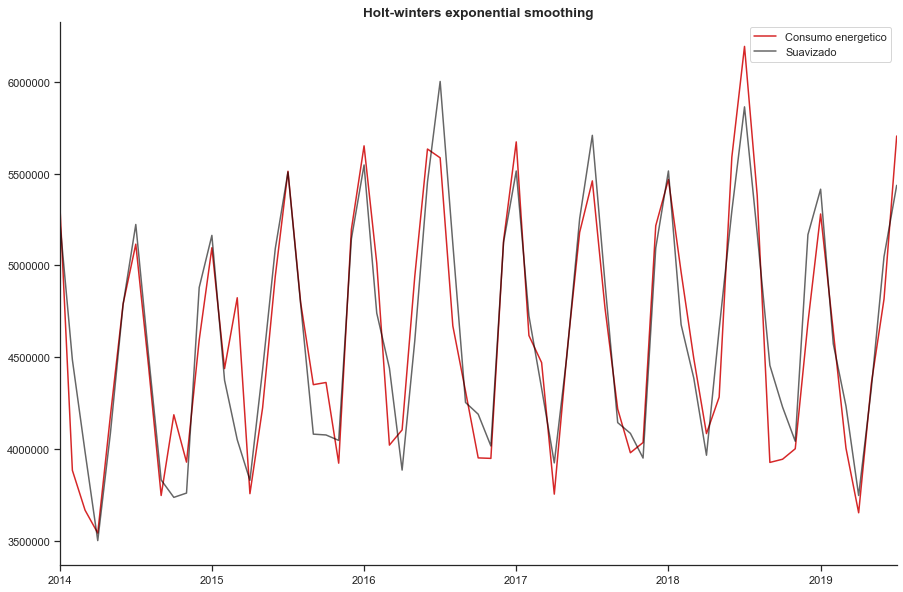

In [23]:
smoothed=pd.Series(mhw_sm.fittedvalues, index=y.index)

fig, ax= plt.subplots()

y['2014':].plot(color='#D62728', label='Consumo energetico')
smoothed['2014':].plot(color='black', label='Suavizado', alpha=0.6)
plt.legend(loc='best')
ax.set_xlabel('')
ax.set_xticks([], minor=True)
ax.set_title(r'Holt-winters exponential smoothing', fontsize=13.5, fontweight='bold')
sns.despine()
plt.show()

## Model diagnostics


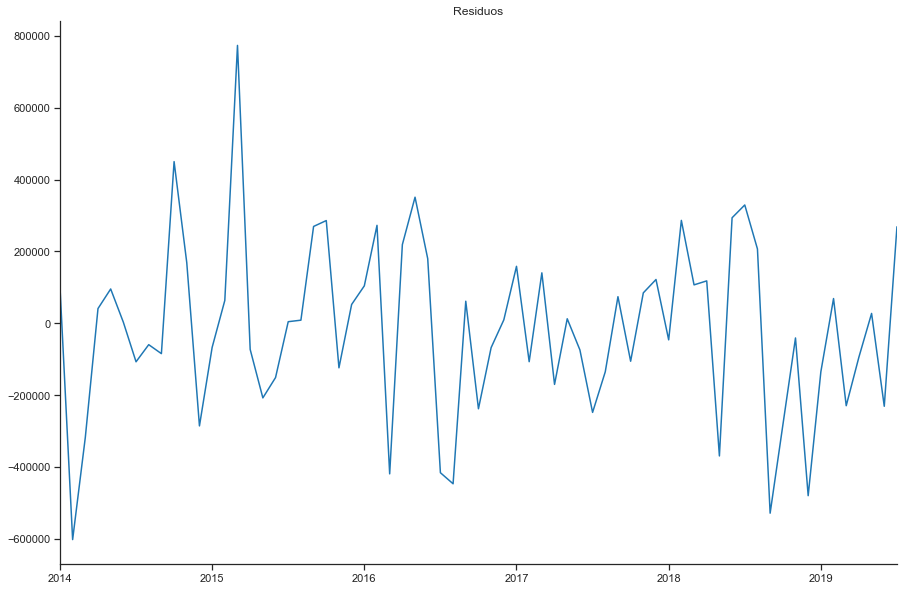

In [24]:
resid = (y-mhw_sm.fittedvalues)[12:] 

fig, ax= plt.subplots()
resid.plot(color=blue)
ax.set_xlabel('')
ax.set_xticks([], minor=True) 
ax.set_title('Residuos')
sns.despine()
plt.show()

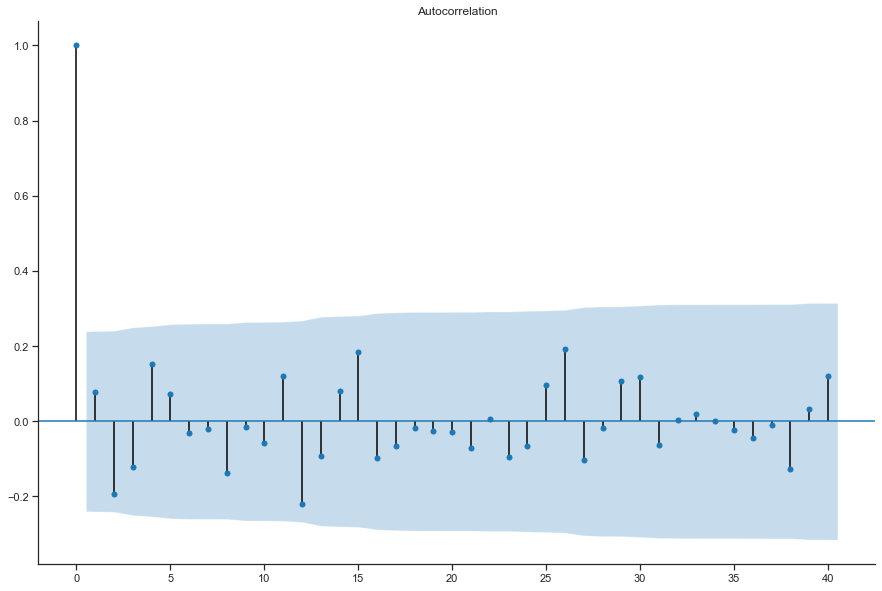

In [26]:
fig, ax = plt.subplots()
sm.graphics.tsa.plot_acf(resid, lags=40, ax=ax)
sns.despine()
plt.show()

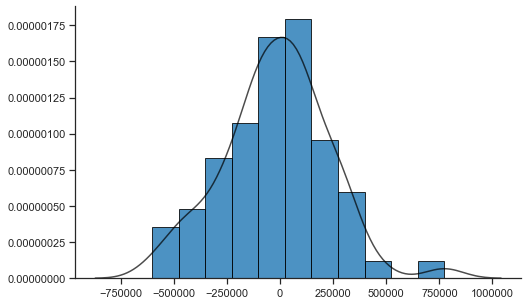

In [27]:
from plotting import histogram

histogram(resid)
plt.show()


Los residuos parecen no tener tendencia, estacionalidad ni ciclos. Al parecer su autocorrelación es pequeña y siguen una distribución aproximadamente normal. En conclusión, parecería no haber problemas con los residuos del modelo, lo que indicaría que el modelo capta bien los componentes de la serie.

## Model validation


In [28]:
start_val = y.index[-round(len(y)/12*.2)*12]
start_val

Period('2018-08', 'M')

Hacer distintos cortes para la validación para ver como va evolucionando cada modelo y obtener el que mejor se ajusta, de esa forma

In [29]:
# Real time forecasting 

validation=y[start_val:].index
start = y.index.get_loc(start_val) 

pred1 = [] # seasonal random walk
pred2 = [] # additive holt winters
pred3 = [] # multiplicative holt winters
actual= []

for i in range(start, len(y)):
    
    actual.append(y.iloc[i]) # actual value
    
    pred1.append(y.iloc[i-12]) # seasonal random walk forecast
    
    model = sm.tsa.ExponentialSmoothing(y.iloc[:i], trend='add', damped=False, seasonal='add', seasonal_periods=12).fit()
    pred2.append(model.forecast(1)[0]) # additive holt winters forecast
    
    model = sm.tsa.ExponentialSmoothing(y.iloc[:i], trend='add', damped=False, seasonal='mul', seasonal_periods=12).fit()
    pred3.append(model.forecast(1)[0]) # multiplicate holt winters forecast
    

columns=['Caminata aleatoria estacional', 'Aditivo', 'Multiplicativo', 'Original']
results = np.vstack([pred1,pred2,pred3,actual]).T
results = pd.DataFrame(results, columns=columns, index=validation)

C:\Users\valen\Anaconda3\envs\diplodatos\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Users\valen\Anaconda3\envs\diplodatos\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Users\valen\Anaconda3\envs\diplodatos\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


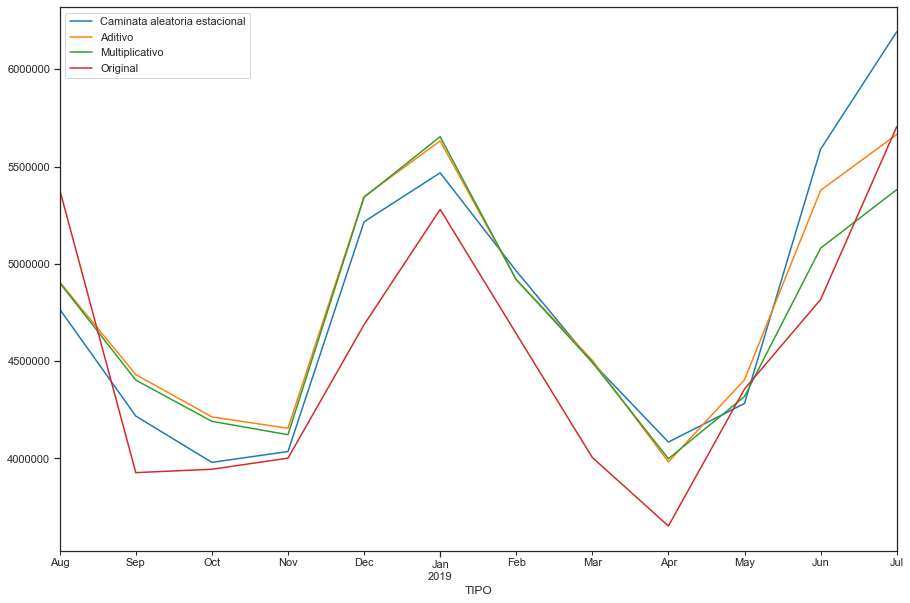

In [30]:
results.plot();

In [31]:
from scipy import stats

table = pd.DataFrame(0.0, index=results.columns[:-1], columns=['RMSE','SE'])
for i in range(len(results.columns)-1):
    table.iloc[i,0] = sm.tools.eval_measures.rmse(results.iloc[:,i], results.iloc[:,-1])
    table.iloc[i,1] = (results.iloc[:,i] - results.iloc[:,-1]).sem()
table.round(3)

,RMSE,SE
Caminata aleatoria estacional,423173.552,104886.183
Aditivo,396541.964,89870.964
Multiplicativo,377599.497,96442.172


## Predicción con el modelo multiplicativo


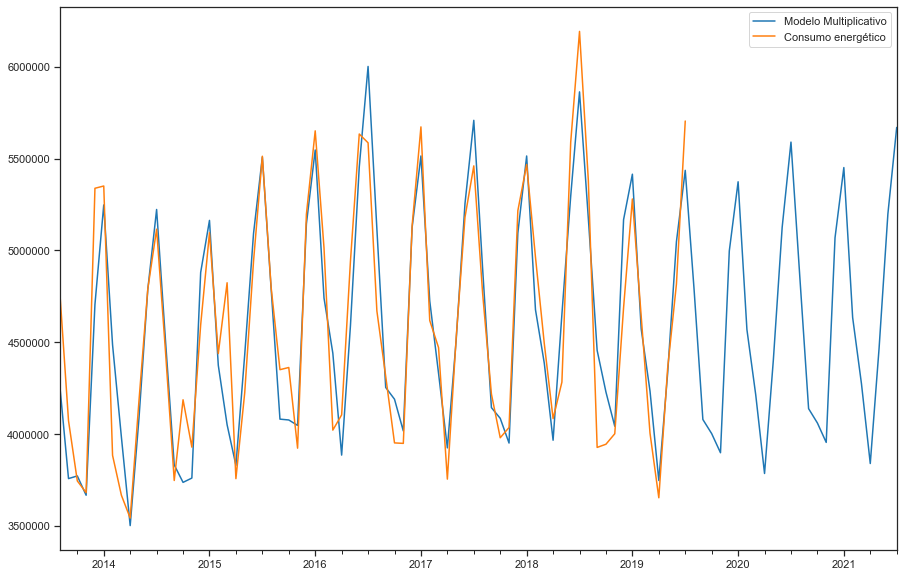

In [32]:
h=2*12 #M
w=h*3

model = sm.tsa.ExponentialSmoothing(y, 
                    trend='add', damped=False, seasonal='mul', seasonal_periods=12).fit()

plot = pd.DataFrame()
plot['Modelo Multiplicativo'] = pd.concat([model.fittedvalues, model.forecast(h)])
plot['Consumo energético'] = y

plot[-(w+h):].plot();#figsize=(9,6))